In [2]:
700 * 500**3 * 8 / 1024**2

667572.021484375

In [6]:
import numpy as np
from scipy.io import savemat, loadmat
import scipy.ndimage as impr
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import sklearn as sk

In [15]:
import sys
sys.path.append('../../')
import src.approximation as appr
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils

from keras import optimizers
import keras

In [2]:
def data_input_layered():
    data = loadmat('../../data/layered_traveltimes.mat')
    vp = loadmat('../../data/layered_model.mat')['vp']
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def data_input_seg():
    data = loadmat('../../data/seg_traveltimes.mat')
    vp = data['SpeedImage'][:,0,:]
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

In [74]:
sou, rec, time, vp = data_input_seg()

In [4]:
import sciann as sn

Using TensorFlow backend.


---------------------- SCIANN 0.4.6.2 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [75]:
Tz = np.gradient(time, axis=-1)
Tz.shape

(201, 201, 201)

In [76]:
np.count_nonzero(Tz < 0)

337201

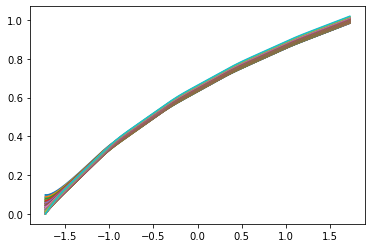

In [66]:
plt.figure()
plt.plot(sou_z_sc, time[:10,:10].reshape(-1, 201).T)
plt.show()

In [68]:
def approximator(nu, nl, act='relu', optimizer='adam'):
    xr = sn.Variable('xr')
    xs = sn.Variable('xs')
    zs = sn.Variable('zs')
    
    T = sn.Functional('T', [xr, xs, zs], [nu]*nl, act)
    
    Tz = sn.math.diff(T, zs)
    M = sn.math.relu(-Tz)
    
    model = sn.SciModel([xr, xs, zs], [T, M], optimizer=optimizer)
    
    return model

In [13]:
sou, rec, time, vp = data_input_layered()

sou_x = sou[:,0,0]
sou_z = sou[0,:,1]
rec_x = rec[:, 0]
output = time[..., None]

scaler_x = ml_utils.Scaler(sou_x)
scaler_z = ml_utils.Scaler(sou_z)
sou_x_sc = scaler_x.scale(sou_x, verbose=True)
sou_z_sc = scaler_z.scale(sou_z)
rec_x_sc = scaler_x.scale(rec_x)

Before scaling:
Mean: 1000.0	Std: 580.22998046875
After scaling:
Mean: 0.0	Std: 1.0


In [14]:
train_set = appr.Approximator.prepare_inputs(inputs=[rec_x_sc, sou_x_sc, sou_z_sc], outputs=output, 
                                                        flatenned=False, sparse=[1,10,10])
test_set = appr.Approximator.prepare_inputs(inputs=[rec_x_sc, sou_x_sc, sou_z_sc], outputs=output, 
                                                        flatenned=False, sparse=[1,1,1])

In [69]:
adam = optimizers.Adam(lr=1e-3, decay=1e-4)
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='mae', min_delta=1e-8, patience=4, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='T_mae', factor=0.75, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-7, cooldown=0, min_lr=1e-7)

callbacks = [
#             early,
            reducer,
#             plot_losses
            ]

In [70]:
model = approximator(3000, 1, optimizer=adam)
model.model.compile(optimizer=adam, loss='mse', metrics=['mae'])

In [50]:
X = np.array(list(train_set[0].values()))
Y = train_set[1].ravel()

In [72]:
model.train([*X], [Y, 'zero'], callbacks=callbacks, 
            batch_size=101, epochs=101, verbose=2)

Epoch 1/101
 - 7s - loss: 0.0100 - T_loss: 0.0097 - relu/27_loss: 3.2933e-04 - T_mae: 0.0422 - relu/27_mae: 0.0059
Epoch 2/101
 - 6s - loss: 0.0018 - T_loss: 0.0015 - relu/27_loss: 2.9964e-04 - T_mae: 0.0227 - relu/27_mae: 0.0067
Epoch 3/101
 - 6s - loss: 0.0018 - T_loss: 0.0015 - relu/27_loss: 2.8988e-04 - T_mae: 0.0230 - relu/27_mae: 0.0068
Epoch 4/101
 - 6s - loss: 0.0018 - T_loss: 0.0015 - relu/27_loss: 2.8196e-04 - T_mae: 0.0230 - relu/27_mae: 0.0068
Epoch 5/101
 - 7s - loss: 0.0018 - T_loss: 0.0015 - relu/27_loss: 2.8007e-04 - T_mae: 0.0227 - relu/27_mae: 0.0068

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 6/101
 - 6s - loss: 0.0018 - T_loss: 0.0015 - relu/27_loss: 2.7581e-04 - T_mae: 0.0220 - relu/27_mae: 0.0068
Epoch 7/101
 - 5s - loss: 0.0017 - T_loss: 0.0015 - relu/27_loss: 2.7461e-04 - T_mae: 0.0219 - relu/27_mae: 0.0068
Epoch 8/101
 - 6s - loss: 0.0017 - T_loss: 0.0014 - relu/27_loss: 2.7612e-04 - T_mae: 0.0214 - relu/27_mae: 0.0068

KeyboardInterrupt: 

In [36]:
Sc = np.random.binomial(1, vp / vp.max())
sc = Sc.ravel()
ind = np.argwhere(sc > 0).squeeze()
sc = sc[ind]
scx = sou.reshape(-1,2)[ind,0]
scz = sou.reshape(-1,2)[ind,1]

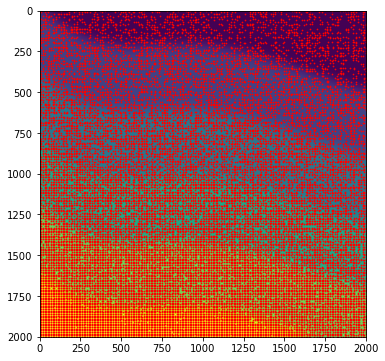

In [40]:
plt.figure(figsize=(6,6))
plt.imshow(vp.T, extent=(0,2000,2000,0))
plt.scatter(scx, scz, s=0.5, c='r')
plt.show()